In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.special import expit  # sigmoid
from scipy.stats import norm


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927

rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
file= "mayflies_salt_survival.csv"

In [4]:
df =  pd.read_csv(file)


In [5]:
df.head()

,N0,Nsurv,conc,Salt
0,9,9,1,NaCl
1,4,4,2,NaCl
2,5,5,4,NaCl
3,6,6,8,NaCl
4,9,7,16,NaCl


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   N0      99 non-null     int64 
 1   Nsurv   99 non-null     int64 
 2   conc    99 non-null     int64 
 3   Salt    99 non-null     object
dtypes: int64(3), object(1)
memory usage: 3.2+ KB


In [7]:
df.describe()

,N0,Nsurv,conc
count,99.000000,99.000000,99.000000
mean,6.090909,2.868687,186.090909
std,2.181045,2.848725,305.636776
min,1.000000,0.000000,1.000000
25%,5.000000,0.000000,4.000000
50%,6.000000,2.000000,32.000000
75%,8.000000,5.000000,256.000000
max,13.000000,11.000000,1024.000000


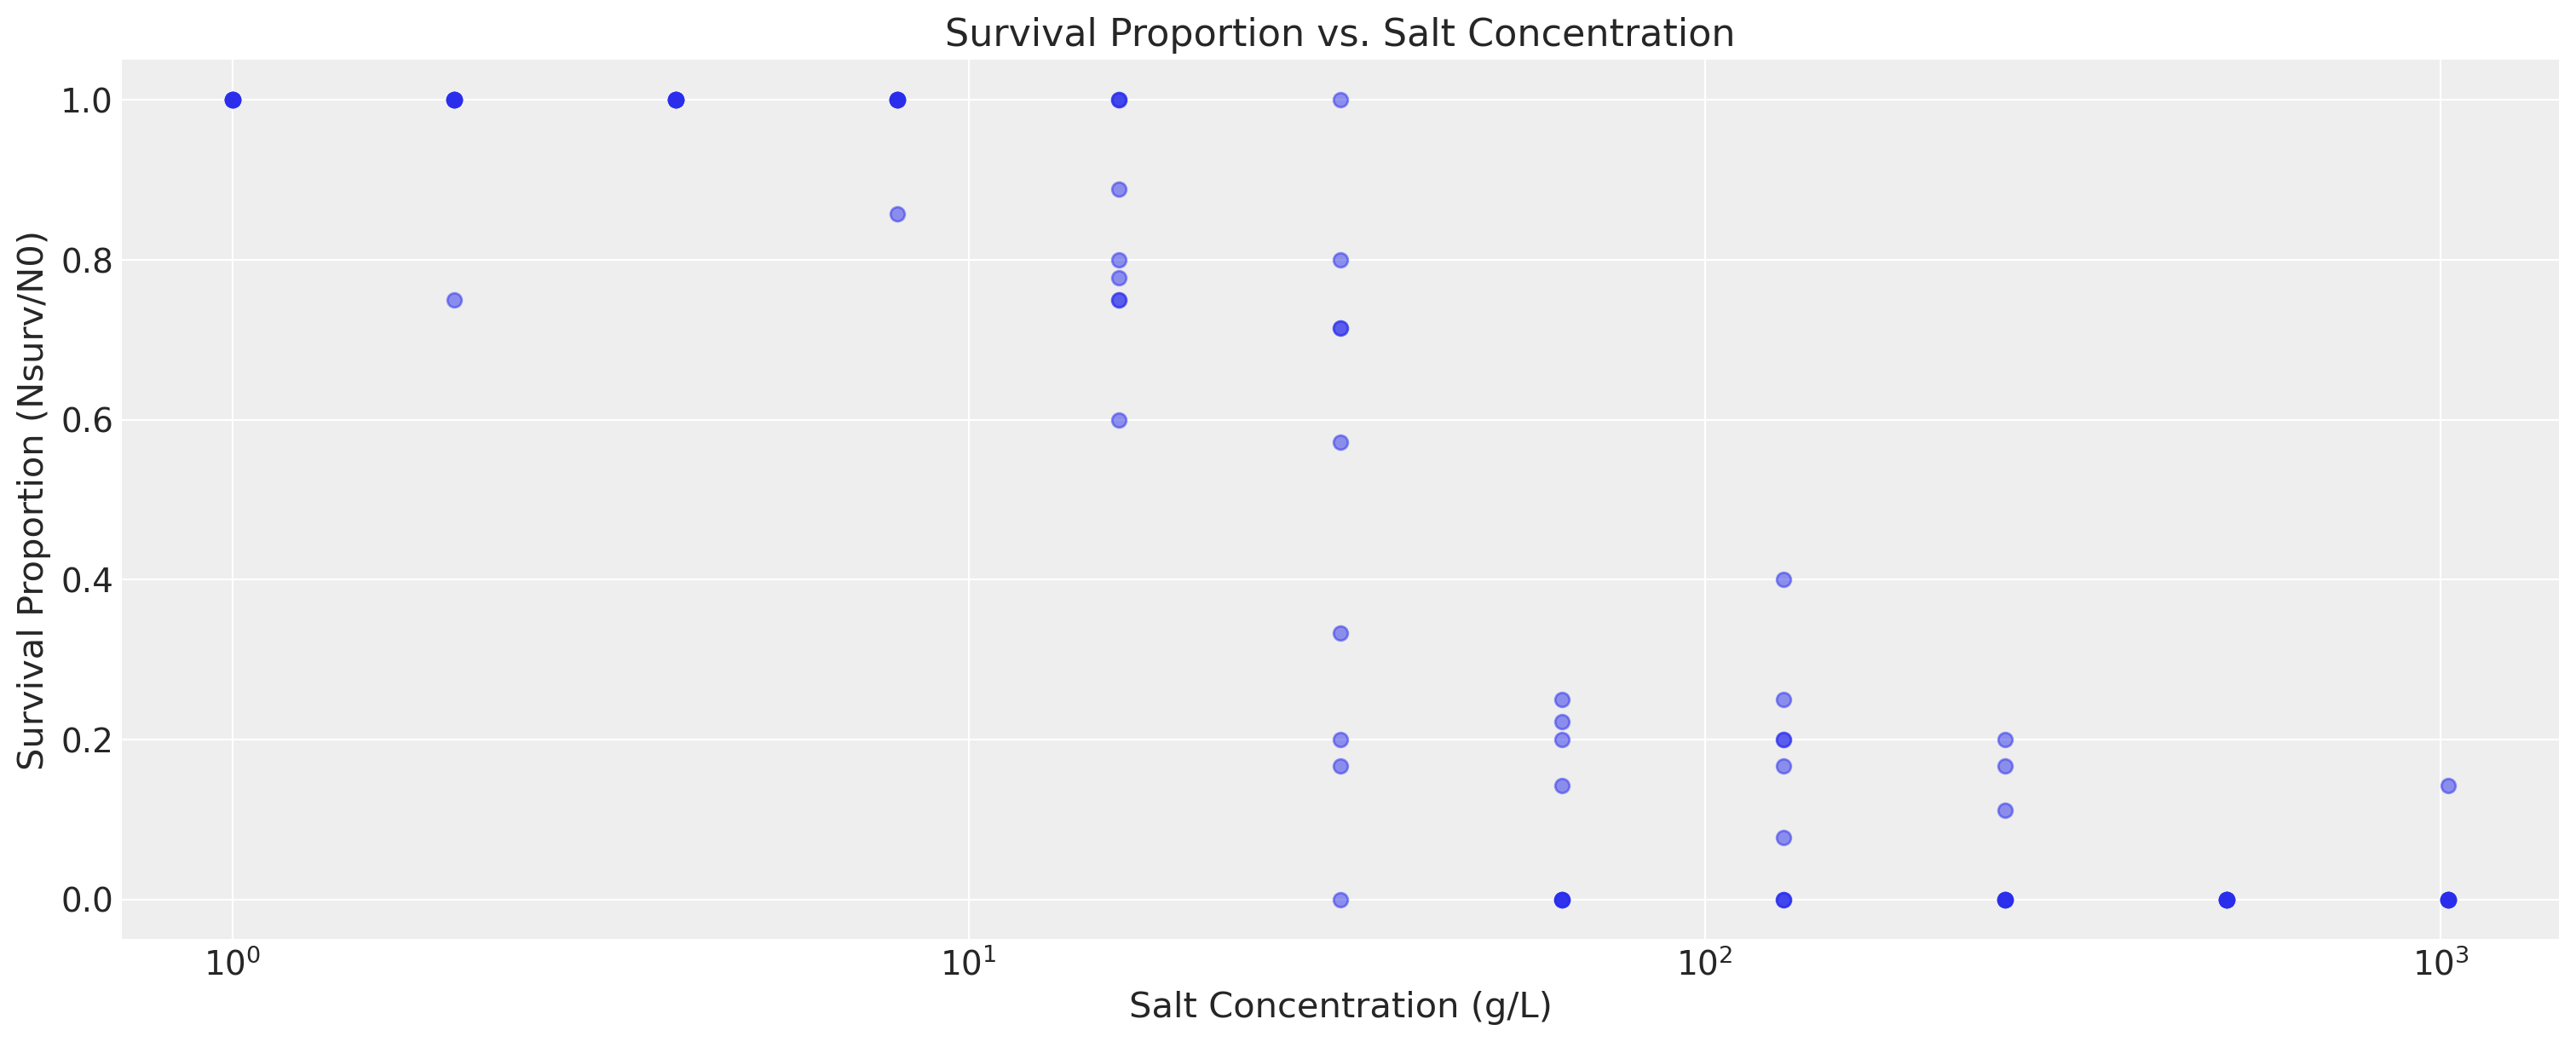

In [8]:
df['survival_proportion'] = df["Nsurv"]/df['N0']
df
plt.figure(figsize=(15, 6))
plt.scatter(df["conc"], df["survival_proportion"], alpha=0.5)
plt.xlabel("Salt Concentration (g/L)")
plt.xscale("log")
plt.ylabel("Survival Proportion (Nsurv/N0)")
plt.title("Survival Proportion vs. Salt Concentration")
plt.grid(True)
plt.show()

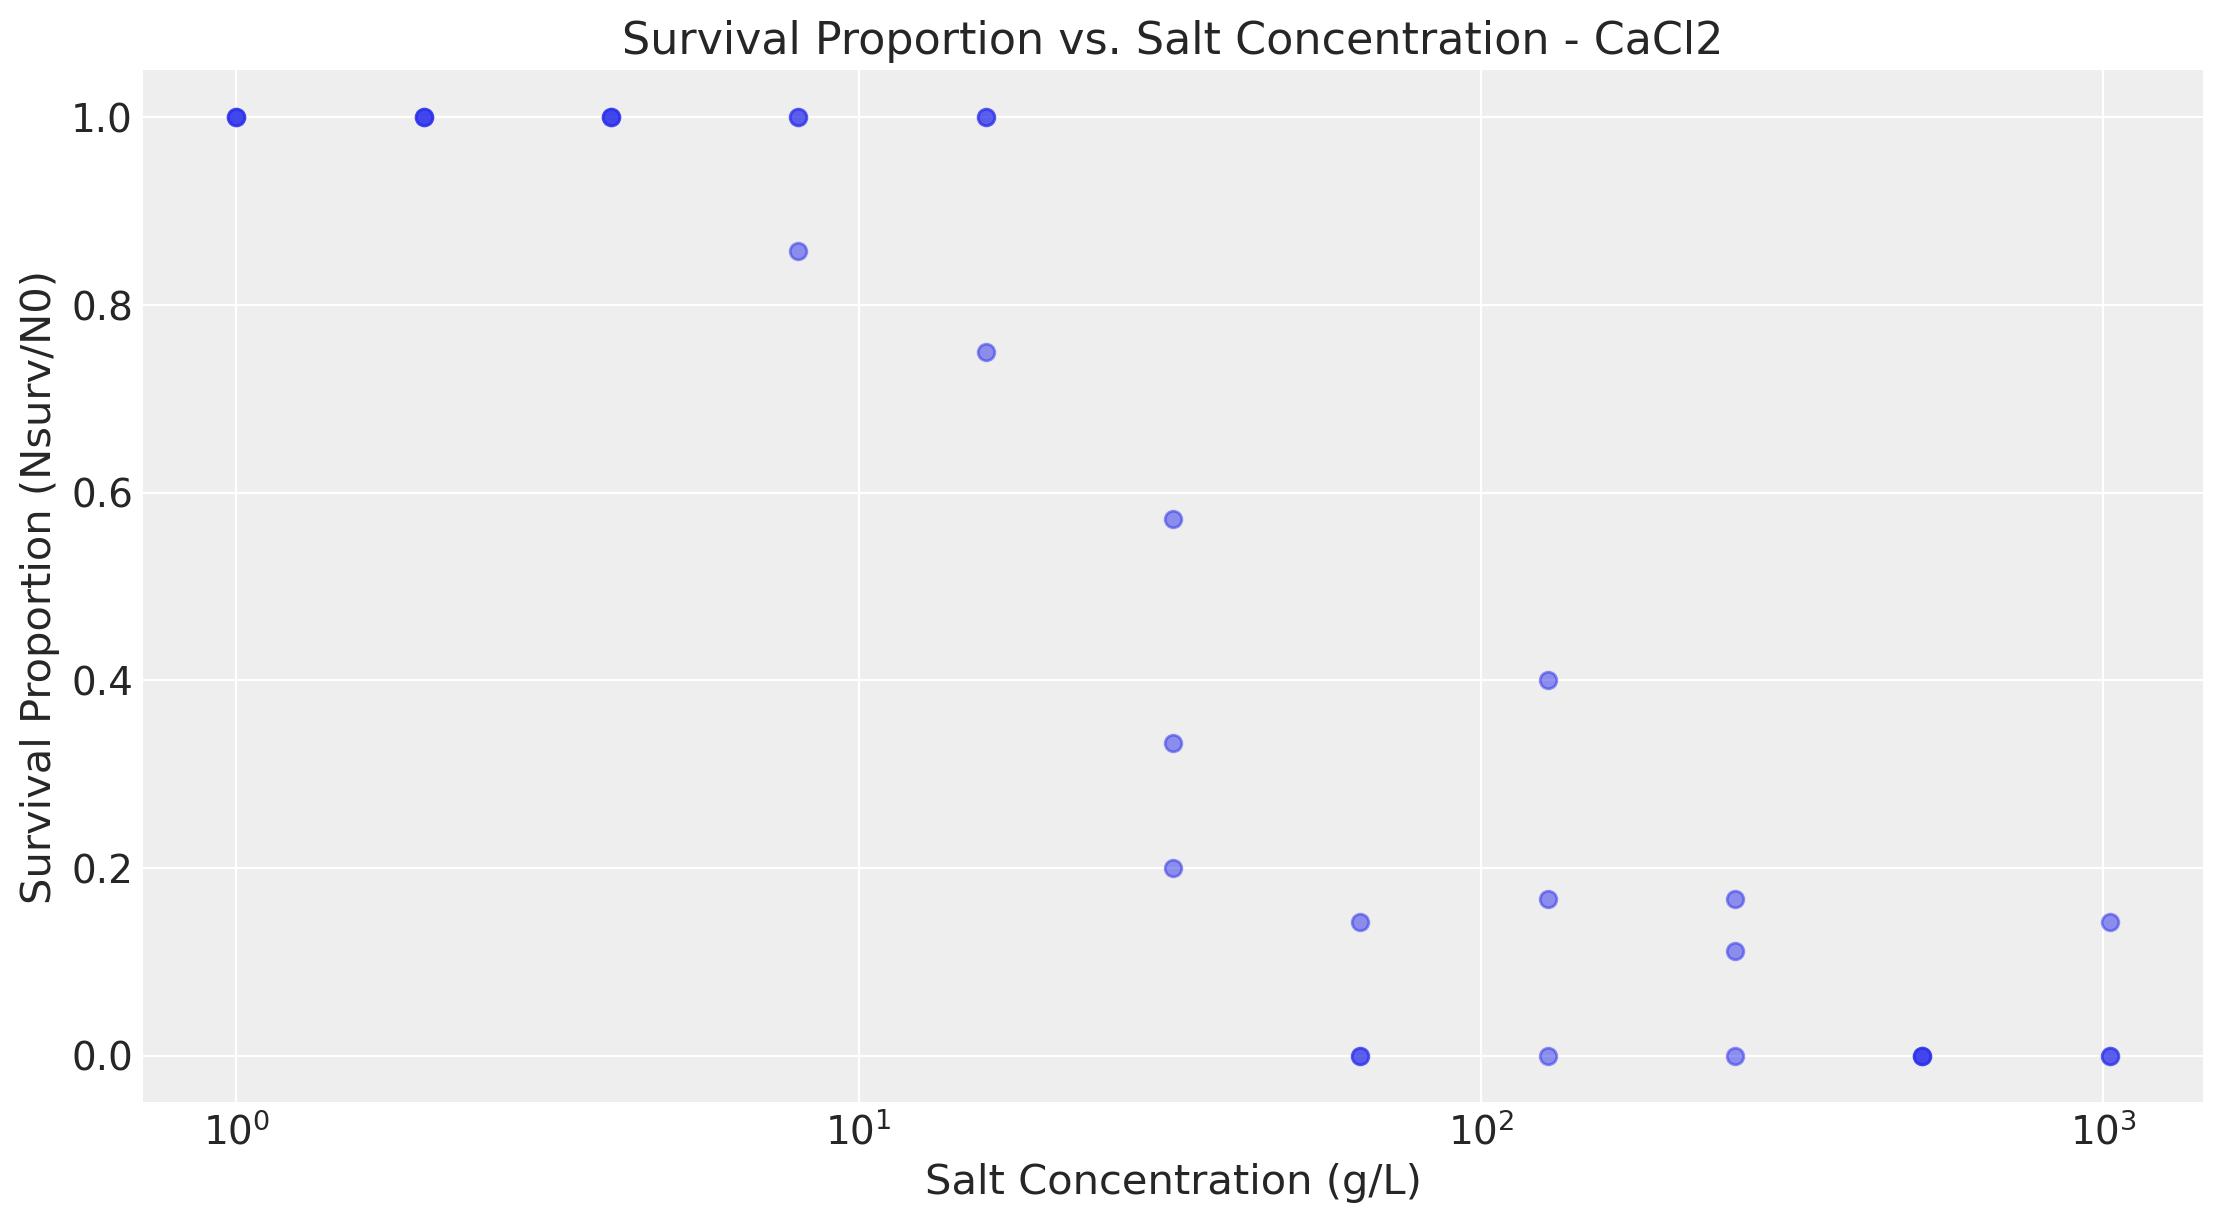

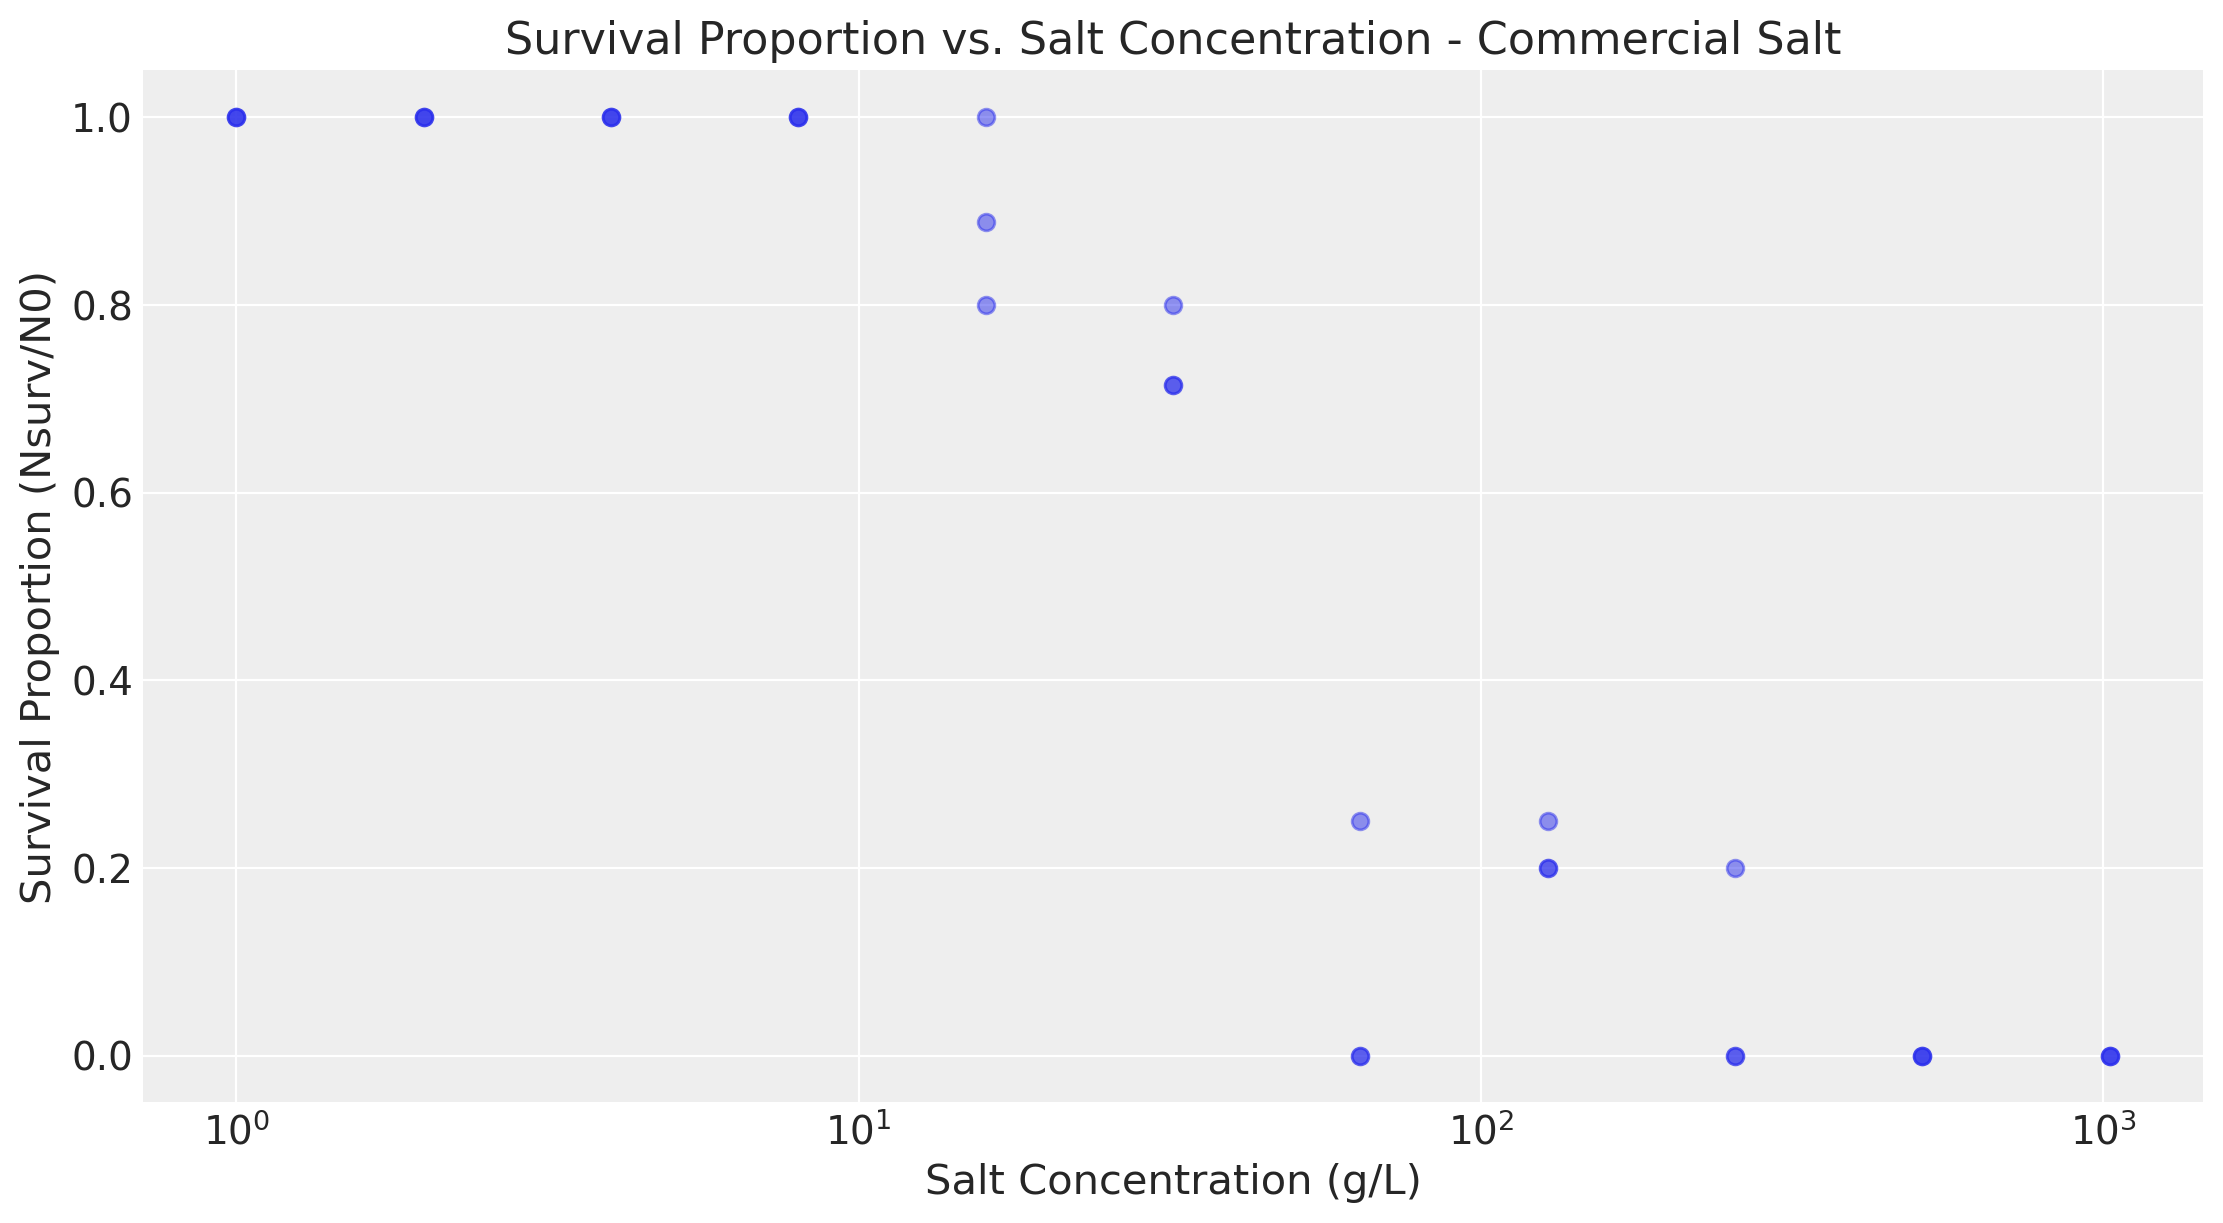

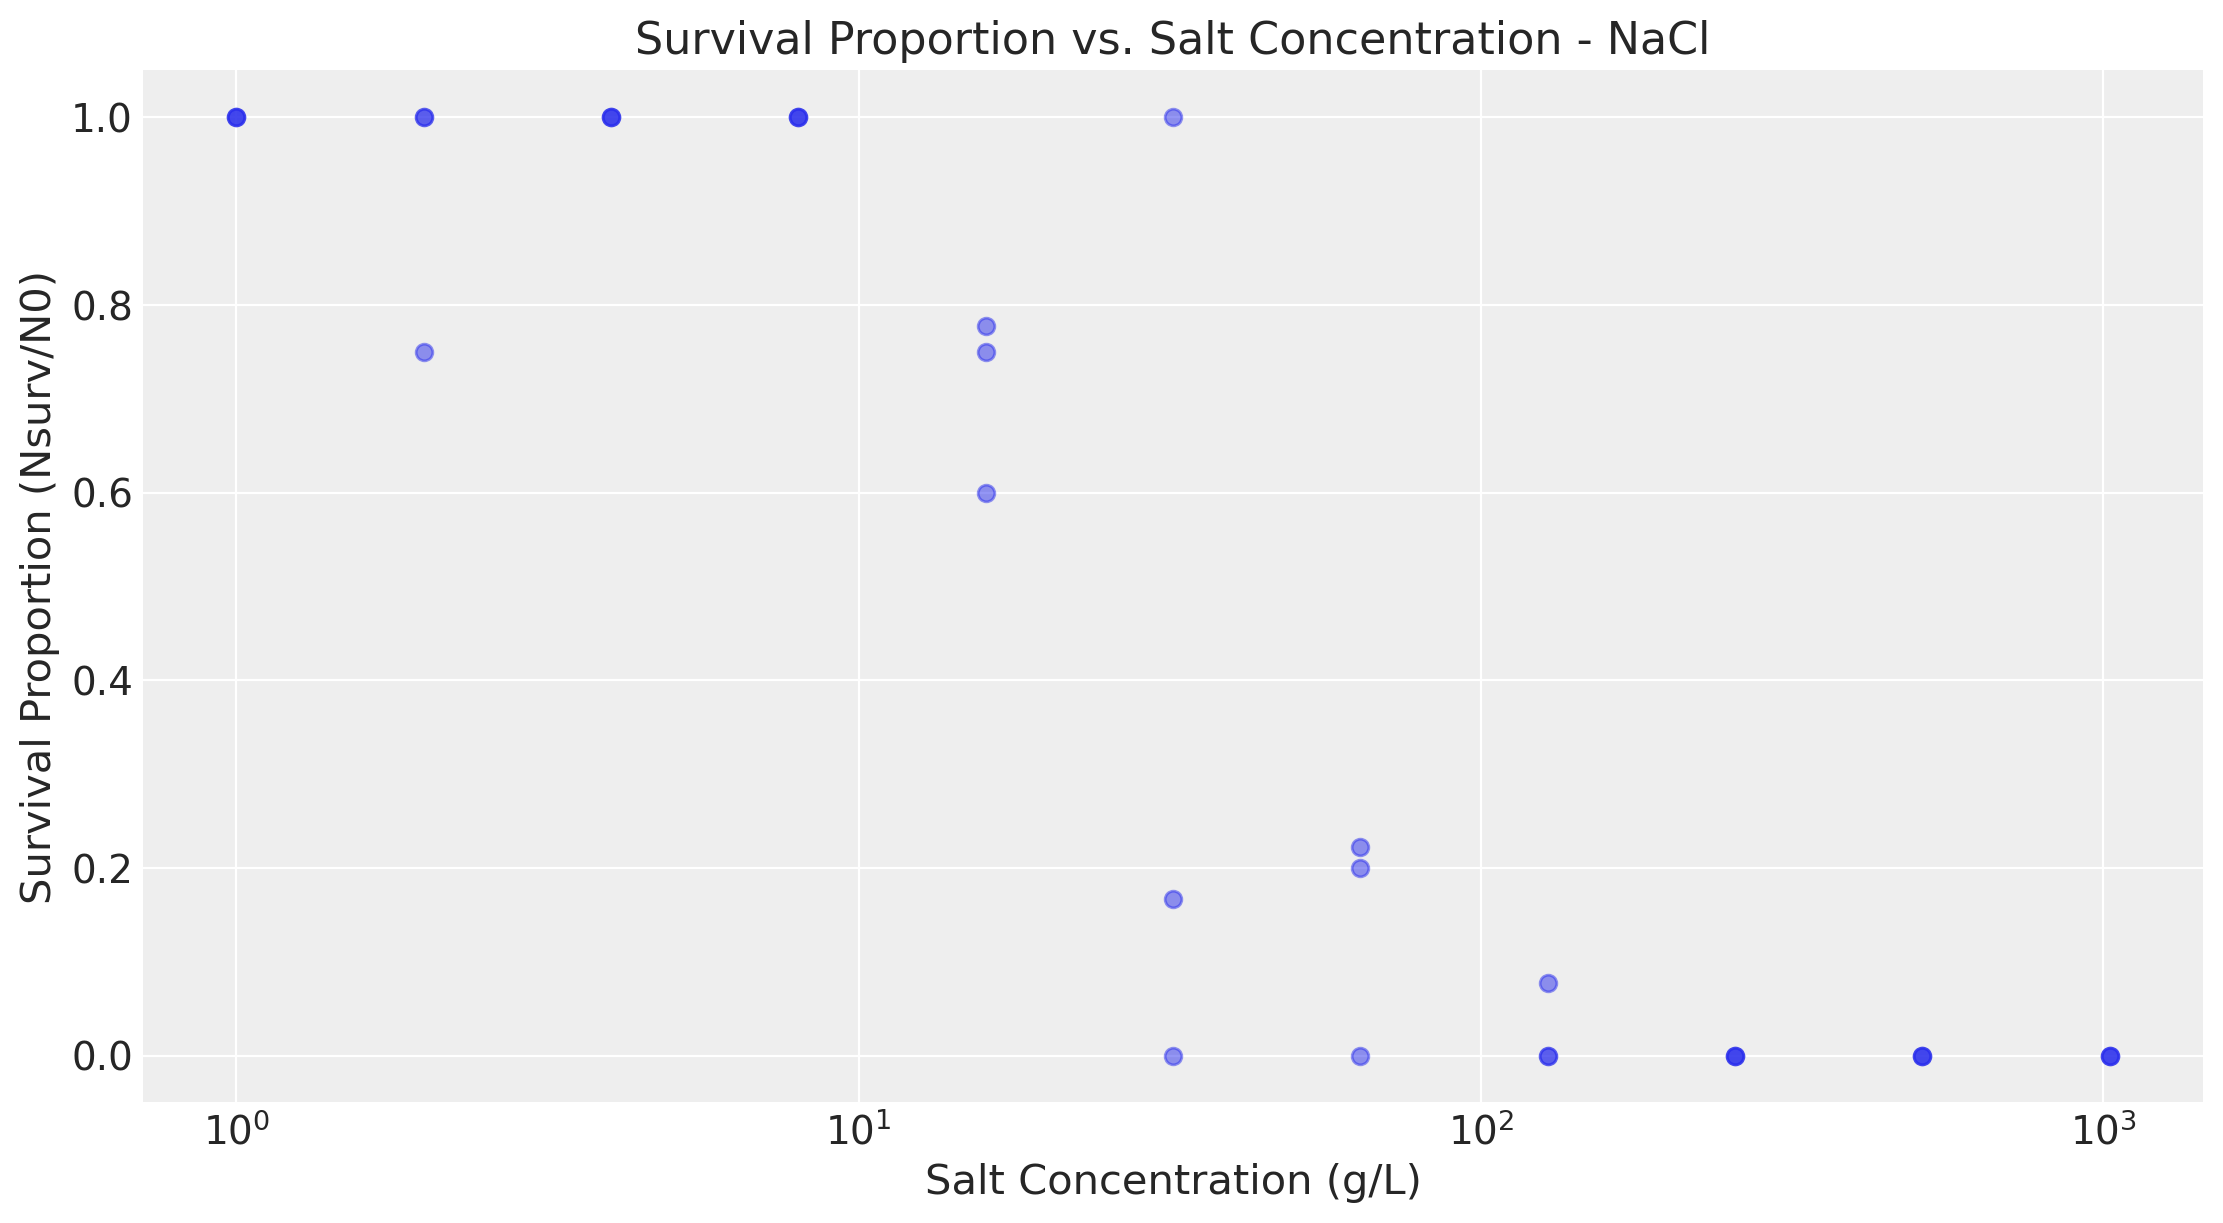

In [9]:
for salt_type, group in df.groupby('Salt'):
    plt.figure(figsize=(11, 6))
    plt.scatter(group['conc'], group['survival_proportion'], alpha=0.5)
    plt.xlabel("Salt Concentration (g/L)")
    plt.xscale('log')
    plt.ylabel("Survival Proportion (Nsurv/N0)")
    plt.title(f"Survival Proportion vs. Salt Concentration - {salt_type}")
    plt.grid(True)
    plt.show()

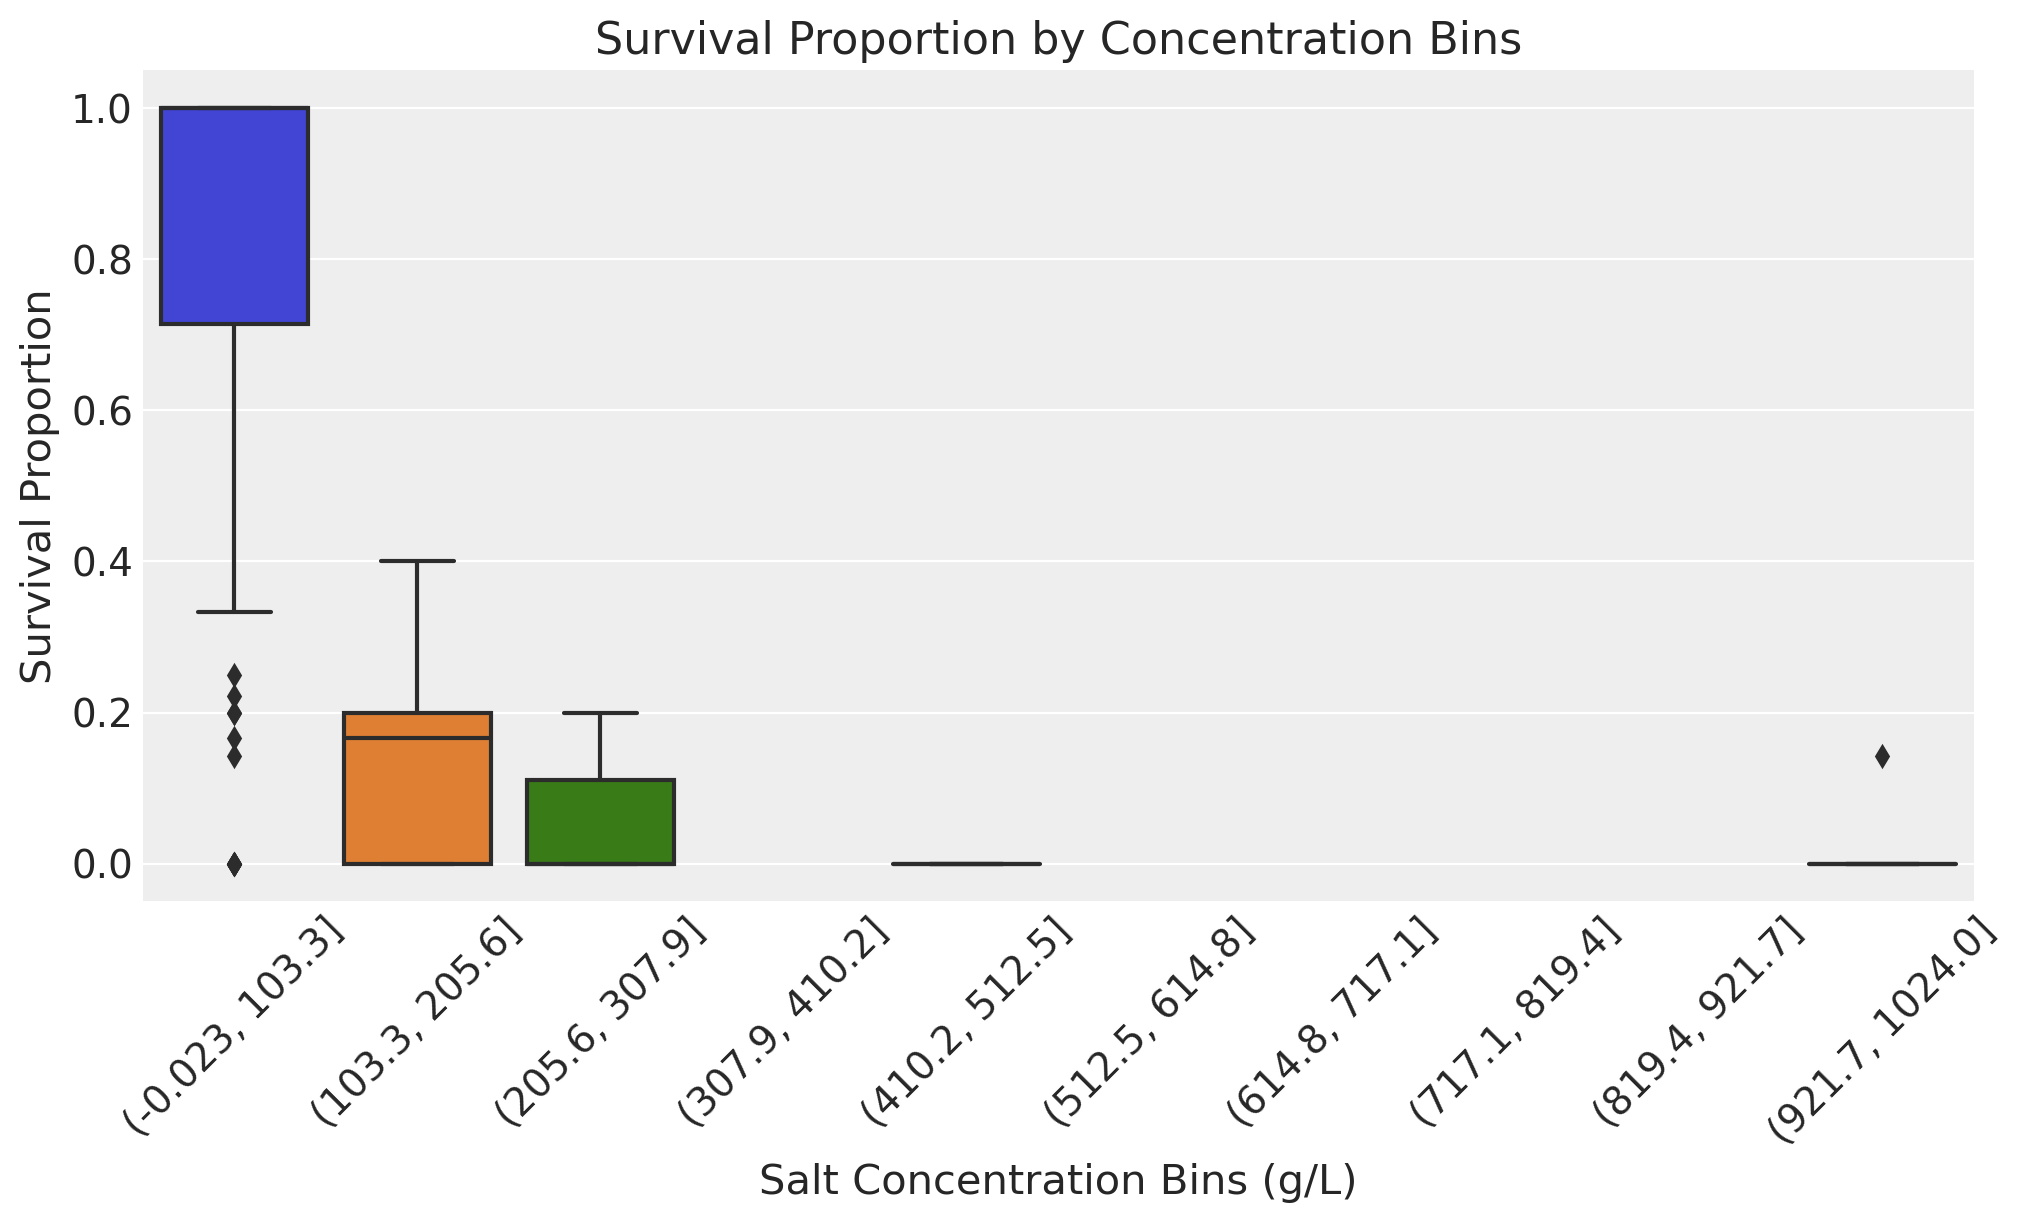

In [10]:

df["conc_bin"] = pd.cut(df["conc"], bins=10)

plt.figure(figsize=(10, 6))
sns.boxplot(x="conc_bin", y="survival_proportion", data=df)
plt.xlabel("Salt Concentration Bins (g/L)")
plt.ylabel("Survival Proportion")
plt.title("Survival Proportion by Concentration Bins")
plt.xticks(rotation=45)
plt.show()

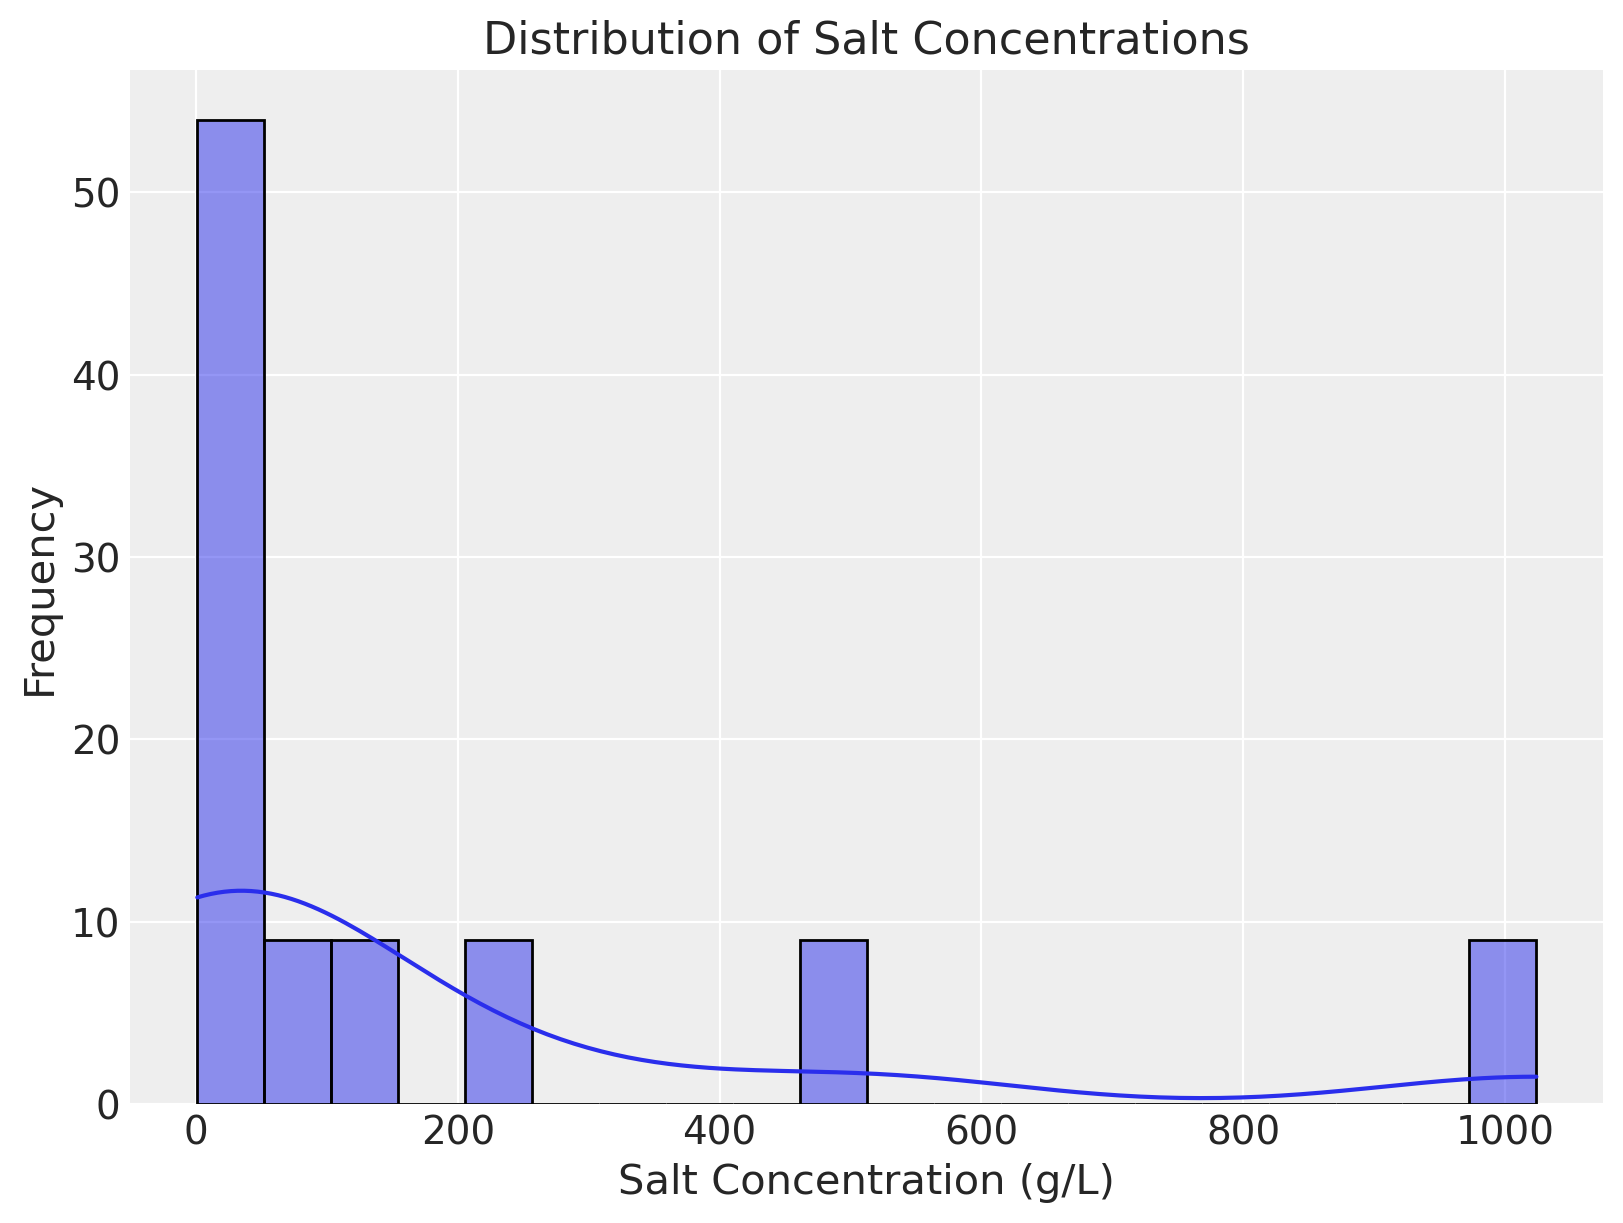

In [31]:
plt.figure(figsize=(8, 6))
sns.histplot(df["conc"], bins=20, kde=True)
plt.xlabel("Salt Concentration (g/L)")
plt.xlabel("Salt Concentration (g/L)")
# plt.xscale("log")
plt.ylabel("Frequency")
plt.title("Distribution of Salt Concentrations")
plt.show()

### Bayesian Logistic Regression Model

In [26]:
conc_normed = (df['conc'] - df['conc'].mean()) /df['conc'].std()

In [27]:
conc_normed

0    -0.605591
1    -0.602319
2    -0.595776
3    -0.582688
4    -0.556513
        ...   
94   -0.399464
95   -0.190065
96    0.228733
97    1.066328
98    2.741519
Name: conc, Length: 99, dtype: float64

In [59]:
log_reg_logit= pm.Model()

with log_reg_logit: #creating a context manager
    # Priors 
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    
    # Logit function: logit(p) = beta_0 + beta_1 * log(conc)
    logit_p = beta_0 + beta_1 * np.log(df['conc'])
    # p = pm.Deterministic("p", pm.math.sigmoid(logit_p))  # Logistic (sigmoid) link function
    #using a probit link (normal cdf )
    p = pm.Deterministic("p", pm.math.invprobit(logit_p))

    # Likelihood (Binomial distribution)
    Nsurv_obs = pm.Binomial("Nsurv", n=df['N0'], p=p, observed=df['Nsurv'])

    # Sampling from the posterior
    log_reg_logit_trace = pm.sample(5000, tune=1000, return_inferencedata=True, target_accept=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


In [61]:
with log_reg_logit:
    print(log_reg_logit.named_vars)   # Liste des variables aléatoires
  
    print(log_reg_logit.basic_RVs)

{'beta_0': beta_0, 'beta_1': beta_1, 'p': p, 'Nsurv': Nsurv}
[beta_0, beta_1, Nsurv]


    1000 tuning samples (warm-up sample) + une variante de Hamiltonian Monte Carlo (HMC)

In [62]:
az.summary(log_reg_logit_trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,3.547,0.278,3.036,4.075,0.005,0.003,3348.0,3266.0,1.0
beta_1,-0.997,0.072,-1.127,-0.858,0.001,0.001,3340.0,3436.0,1.0
p[0],1.000,0.000,0.999,1.000,0.000,0.000,3348.0,3266.0,1.0
p[1],0.997,0.002,0.994,1.000,0.000,0.000,3422.0,3442.0,1.0
p[2],0.983,0.008,0.969,0.996,0.000,0.000,3581.0,3679.0,1.0
...,...,...,...,...,...,...,...,...,...
p[94],0.275,0.030,0.218,0.330,0.000,0.000,16913.0,12545.0,1.0
p[95],0.100,0.021,0.062,0.138,0.000,0.000,7681.0,9095.0,1.0
p[96],0.025,0.009,0.009,0.042,0.000,0.000,5348.0,6613.0,1.0
p[97],0.004,0.003,0.001,0.009,0.000,0.000,4557.0,5133.0,1.0


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

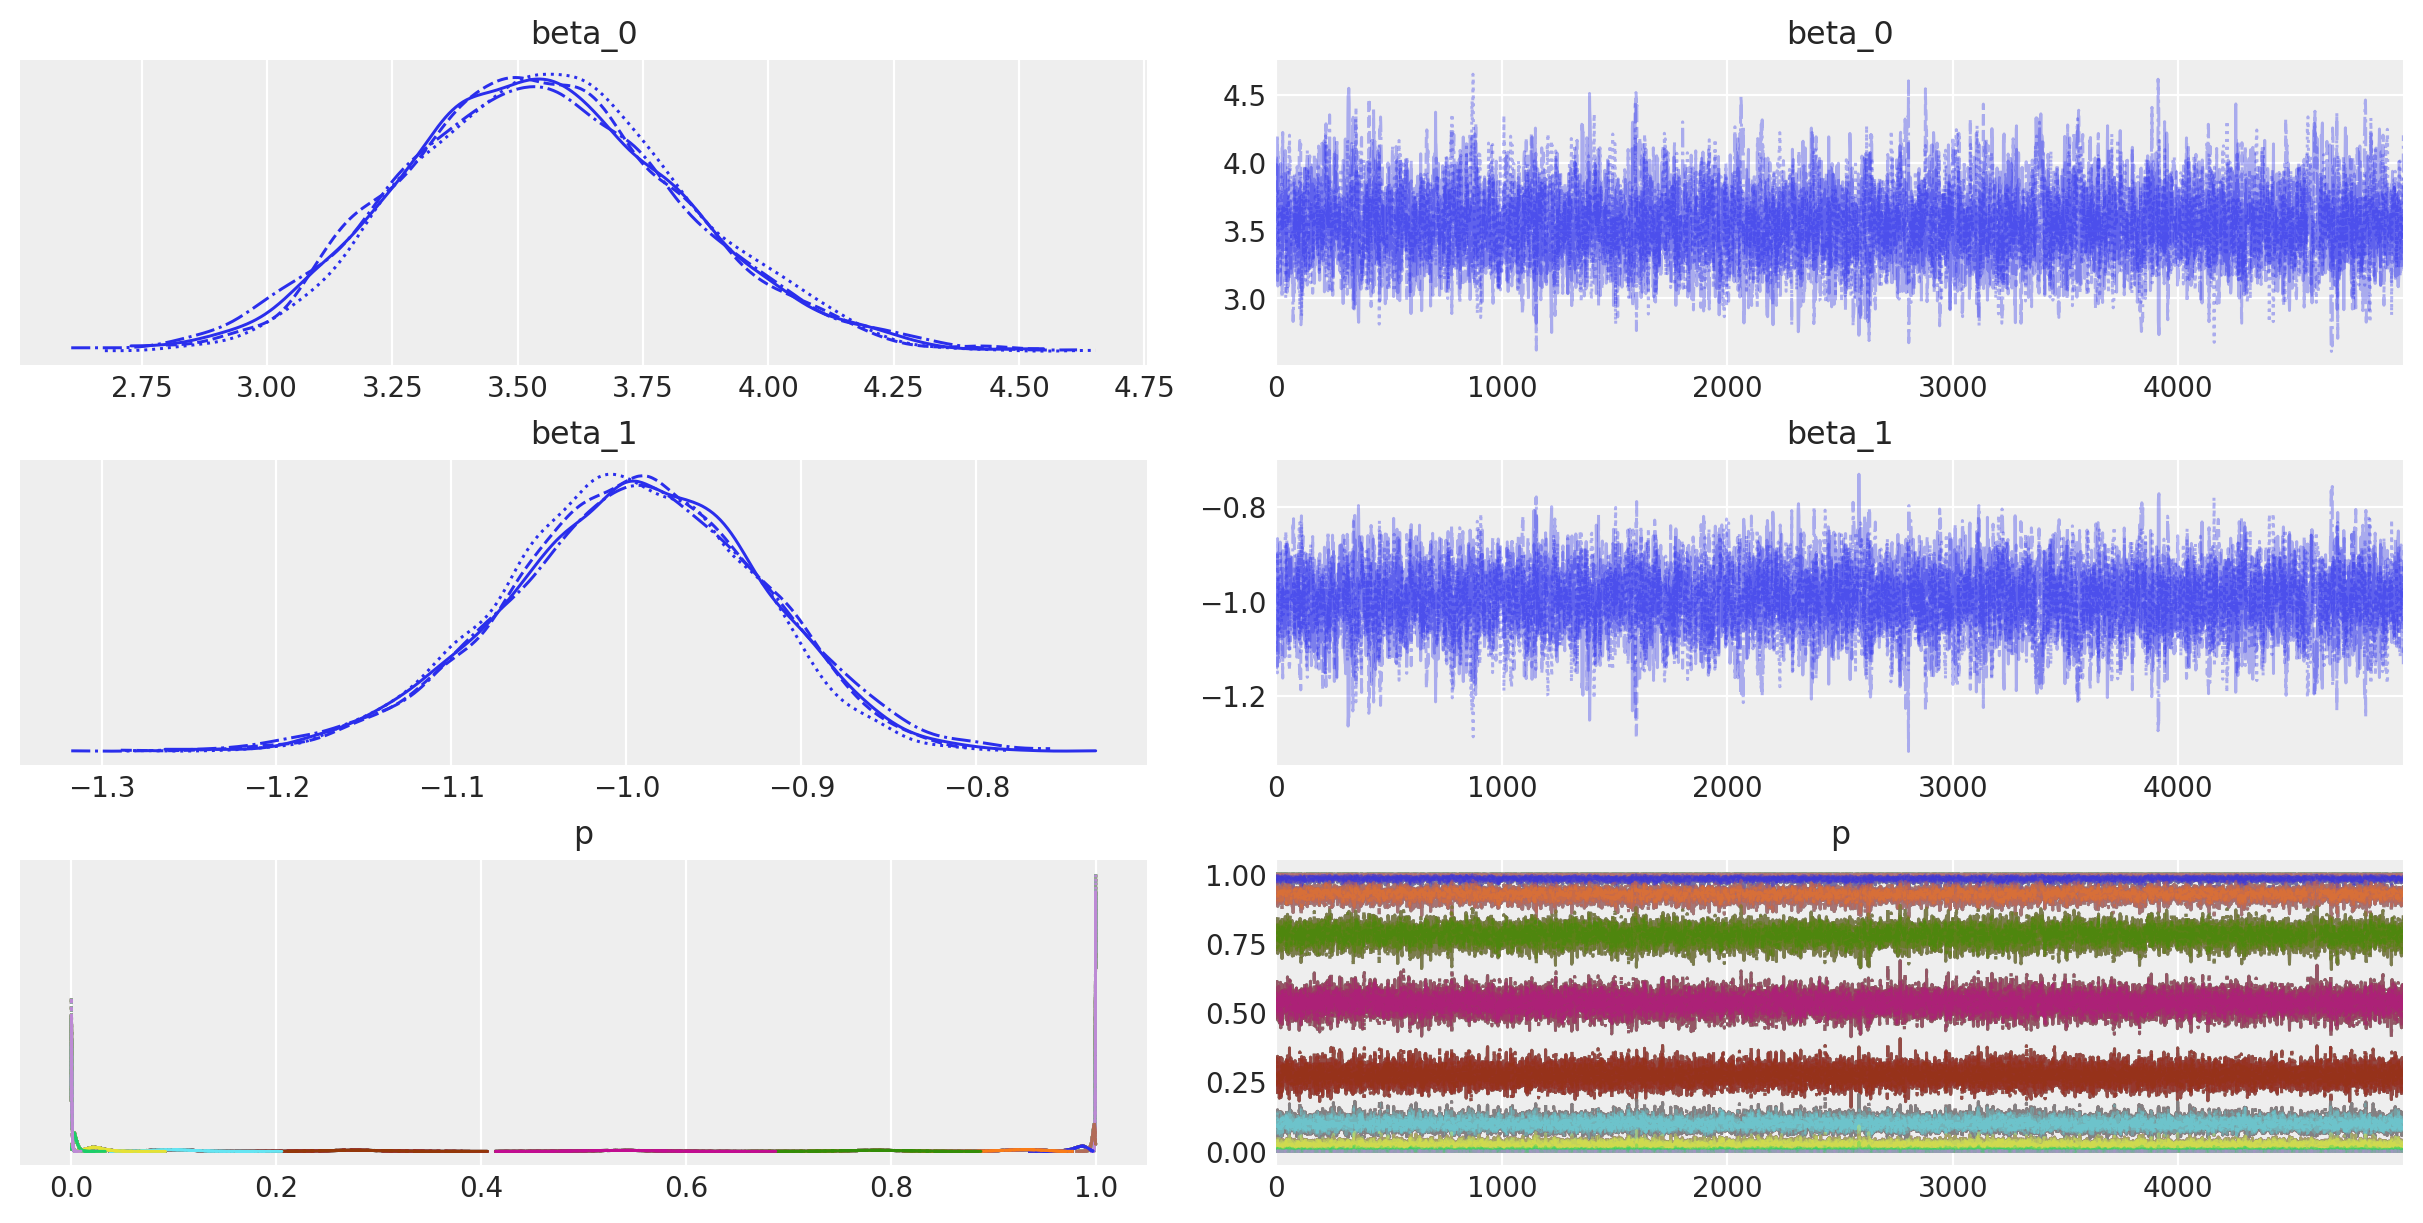

In [63]:
az.plot_trace(log_reg_logit_trace) #traces temporelles  
# le troisieme c'est quelque variables latentes dans le modele bayesien

In [32]:
# az.plot_posterior(log_reg_trace)


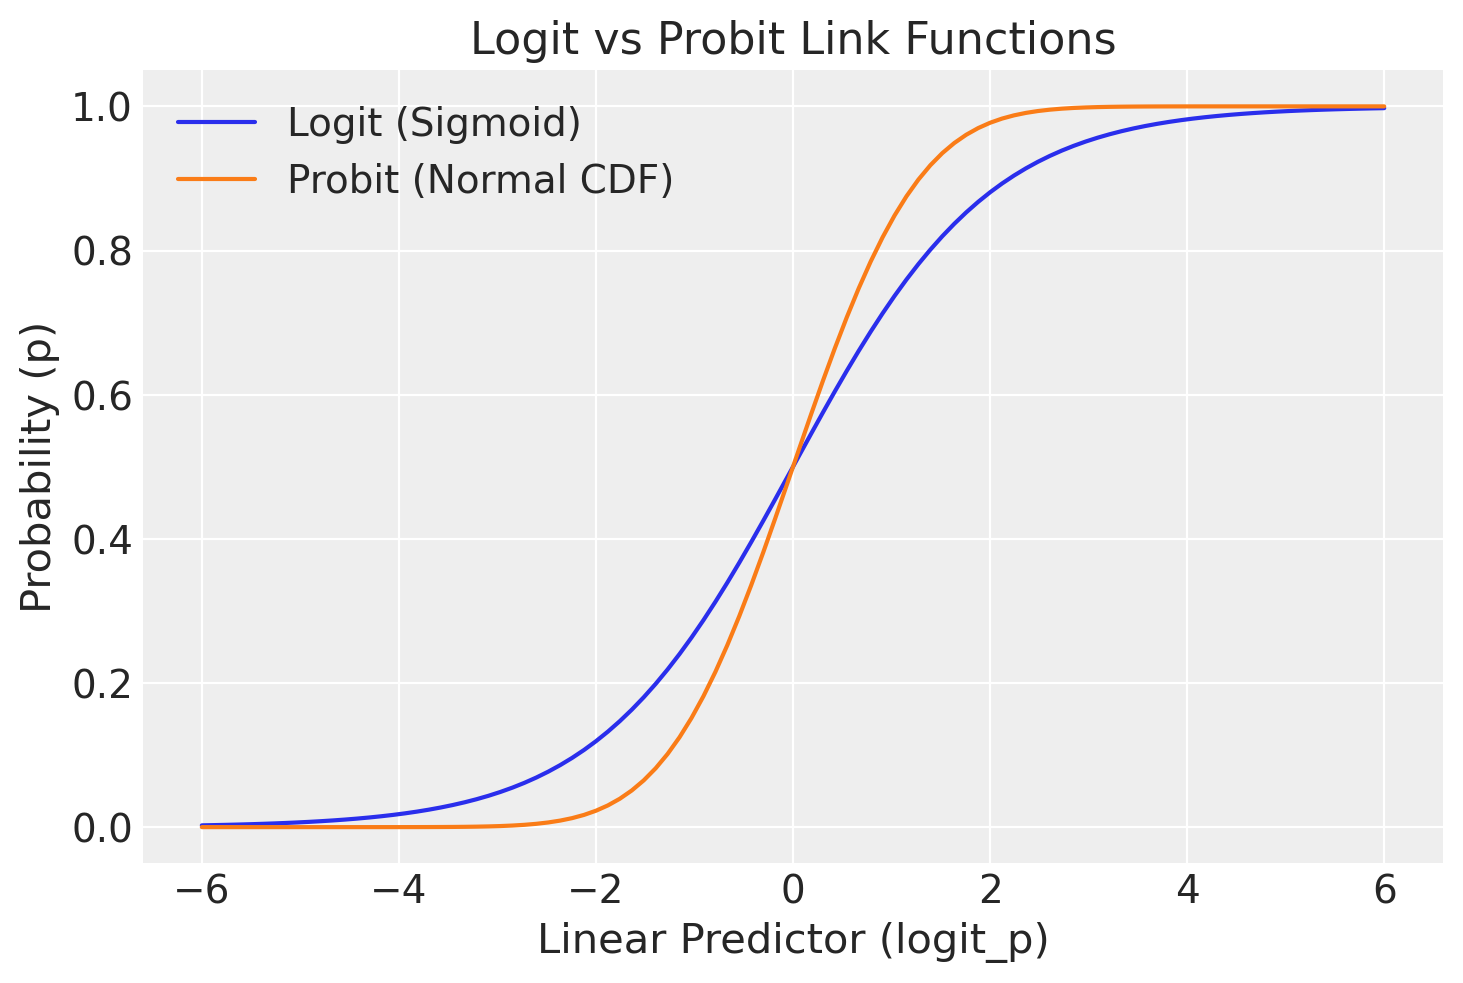

In [35]:
logit_p = np.linspace(-6, 6, 100)
p_logit = expit(logit_p)  # sigmoid
p_probit = norm.cdf(logit_p)  # probit approximation

plt.plot(logit_p, p_logit, label="Logit (Sigmoid)")
plt.plot(logit_p, p_probit, label="Probit (Normal CDF)")
plt.xlabel("Linear Predictor (logit_p)")
plt.ylabel("Probability (p)")
plt.legend()
plt.title("Logit vs Probit Link Functions")
plt.show()

In [66]:
log_reg_probit= pm.Model()

with log_reg_probit: #creating a context manager
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    
    logit_p = beta_0 + beta_1 * np.log(df['conc'])
    #using a probit link (normal cdf )
    p = pm.Deterministic("p", pm.math.invprobit(logit_p)) #invprobit is the same as guassian cdf..
    Nsurv_obs = pm.Binomial("Nsurv", n=df['N0'], p=p, observed=df['Nsurv'])

    log_reg_probit_trace = pm.sample(5000, tune=1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5 seconds.


In [92]:
# (we could also extract these directly from ArviZ Summary..)
beta_0_logit_mean = log_reg_logit_trace.posterior["beta_0"].mean().values
beta_1_logit_mean = log_reg_logit_trace.posterior["beta_1"].mean().values

In [76]:
beta_0_probit_mean= log_reg_probit_trace.posterior["beta_0"].mean().values
beta_1_probit_mean= log_reg_probit_trace.posterior["beta_1"].mean().values


In [116]:
conc_range = np.linspace(df['conc'].min(), df['conc'].max(), 2000)


In [117]:
logit_p_probit = beta_0_probit_mean + beta_1_probit_mean * np.log(conc_range)
logit_p_logit = beta_0_logit_mean + beta_1_logit_mean * np.log(conc_range)

p_probit = norm.cdf(logit_p_probit)
p_logit = expit(logit_p_logit)



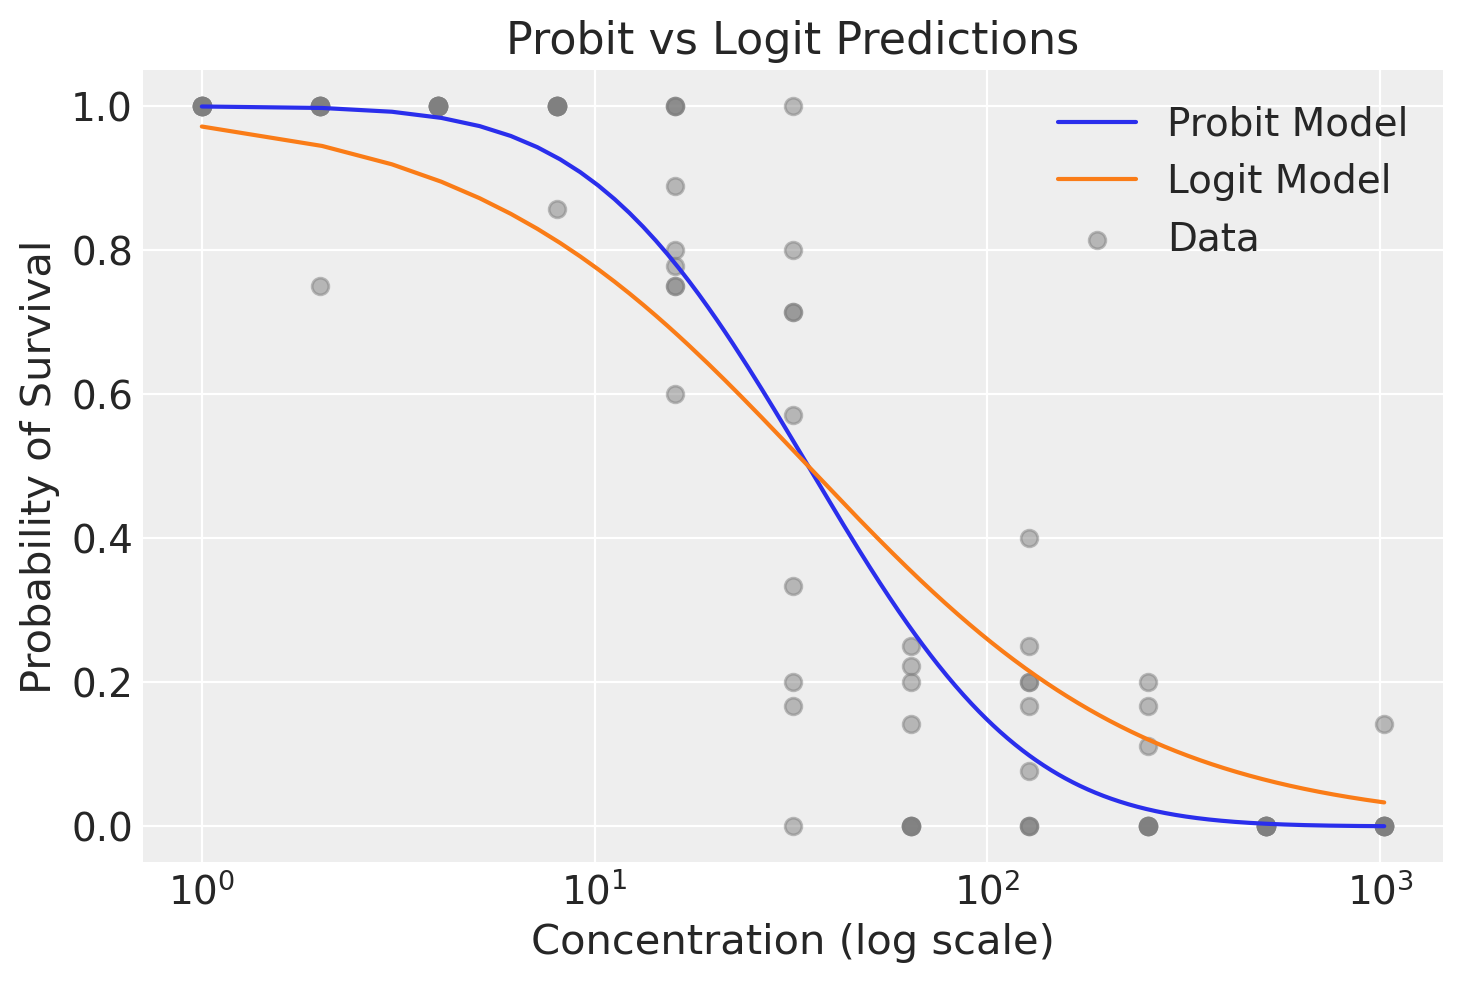

In [78]:
plt.plot(conc_range, p_probit, label="Probit Model")
plt.plot(conc_range, p_logit, label="Logit Model")
plt.scatter(df['conc'], df['Nsurv']/df['N0'], color='gray', alpha=0.5, label="Data")
plt.xlabel("Concentration (log scale)")
plt.xscale("log")
plt.ylabel("Probability of Survival")
plt.legend()
plt.title("Probit vs Logit Predictions")
plt.show()

Sampling: [Nsurv]


Sampling: [Nsurv]


<Axes: xlabel='Nsurv / Nsurv'>

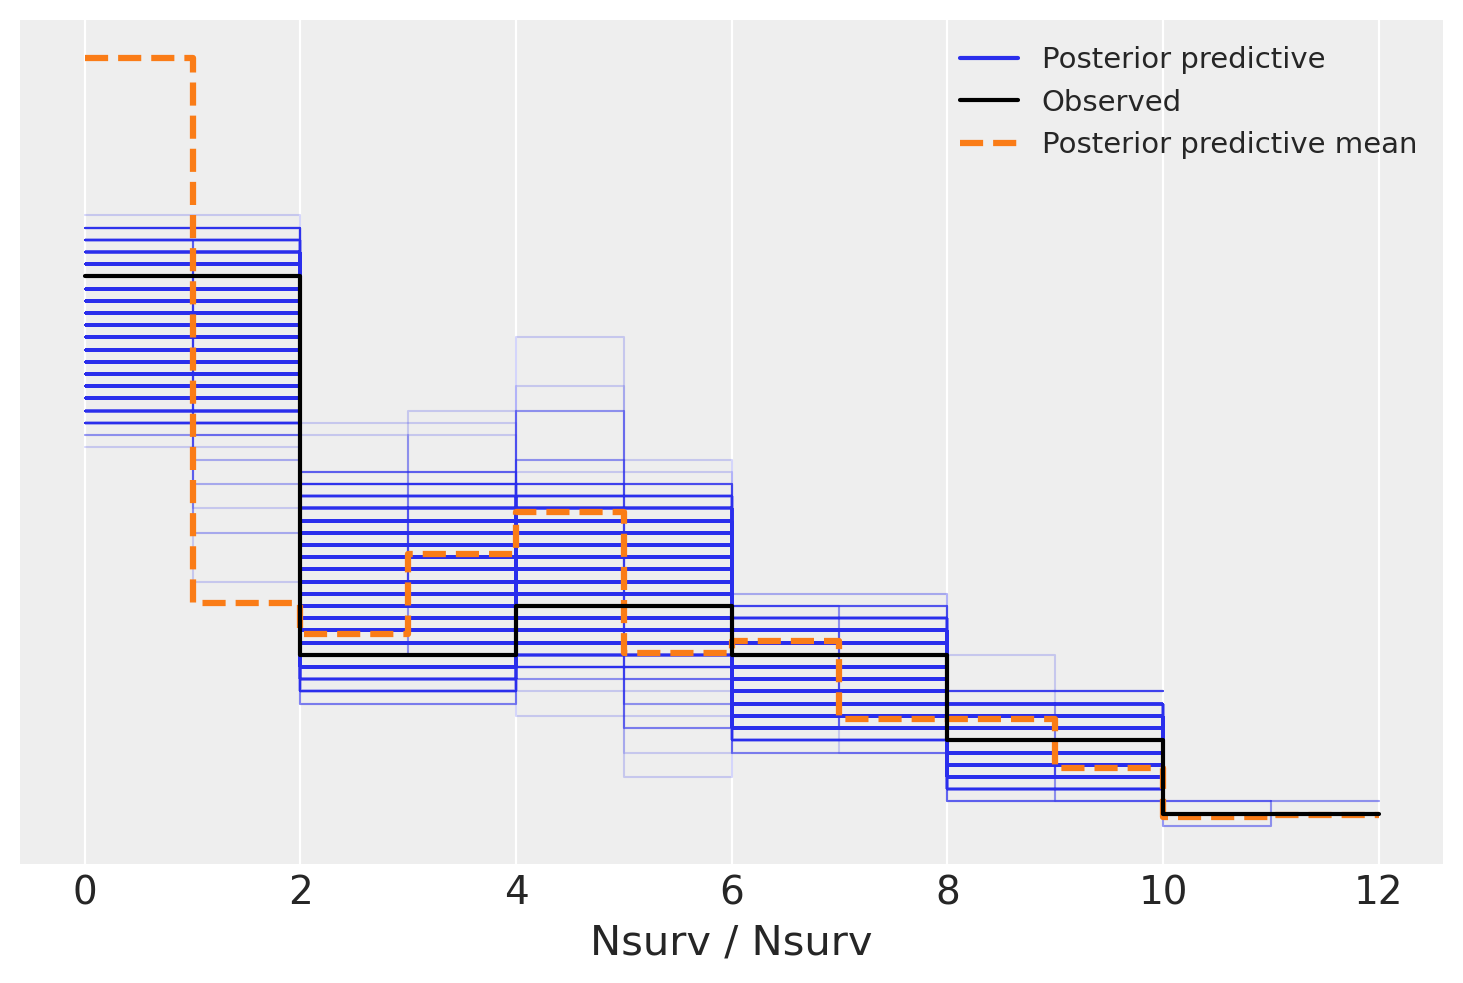

In [82]:
with log_reg_probit:  # probit model
    ppc_probit = pm.sample_posterior_predictive(log_reg_probit_trace)
with log_reg_logit:
    ppc_logit = pm.sample_posterior_predictive(log_reg_logit_trace)

az.plot_ppc(ppc_probit, group="posterior")


    the observed data consistently lies within the range of posterior predictions but not so well with the mean prediction in the beginning , we can say the model is somewhat well-calibrated. 
    (Significant deviations might indicate that the model does not adequately capture the data structure.)

<Axes: xlabel='Nsurv / Nsurv'>

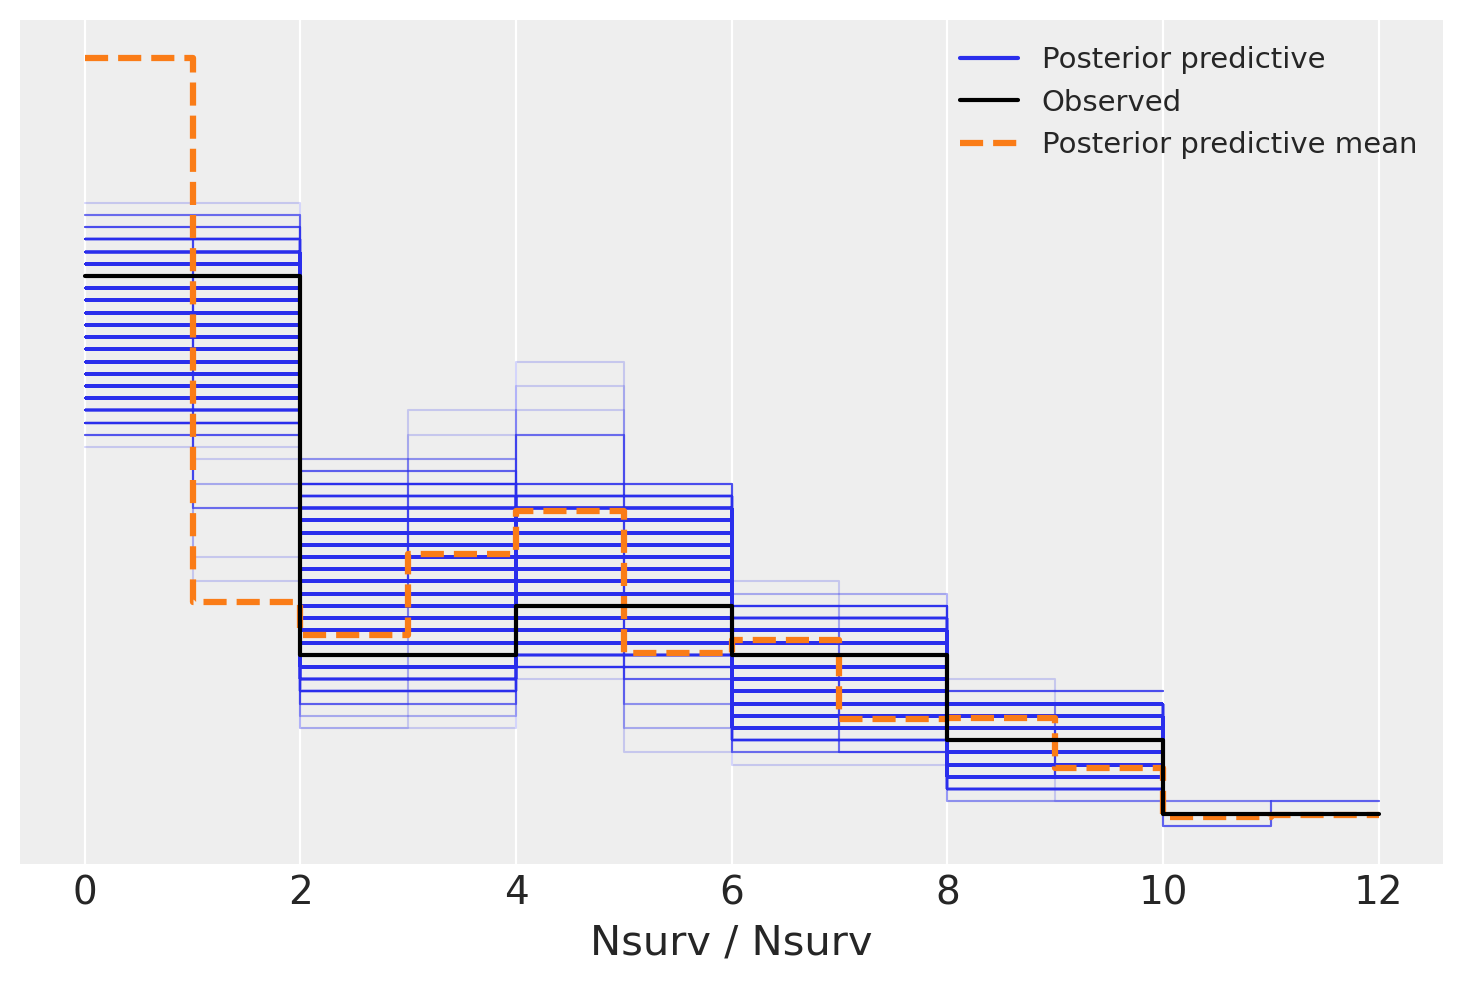

In [91]:
az.plot_ppc(ppc_logit, group="posterior")


In [ ]:
# log_reg_logit_trace.posterior['beta_0']

<xarray.DataArray 'beta_0' (chain: 4, draw: 5000)>
array([[3.88528497, 3.89002718, 3.98569457, ..., 3.76901393, 3.84576854,
        3.27189405],
       [3.19933802, 3.19865332, 3.23480807, ..., 3.51116644, 3.35542164,
        3.3575519 ],
       [4.03785759, 4.03752412, 4.00965429, ..., 3.43013496, 3.37637006,
        3.44126934],
       [4.0435156 , 3.93614339, 3.78713825, ..., 3.71089535, 3.7335423 ,
        4.20344937]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999

In [108]:
from scipy.stats import t
import pytensor.tensor as tt

def student_t_cdf(x, nu):
    # Standard Student’s t CDF: t.cdf(x, df=nu)
    # Using the regularized incomplete beta function
    t = x / tt.sqrt(nu / (nu + x**2))
    cond = tt.switch(x >= 0, 1, 0)
    z = nu / (nu + x**2)
    I = 0.5 * tt.betainc(nu/2, 0.5, z)
    return cond + (1 - 2 * cond) * I

log_reg_robit = pm.Model()
with log_reg_robit:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)  # Degree of freedom parameter

    # Robit link function: robit(p) = StudentT_cdf(log(conc), nu)
    linear_pred = beta_0 + beta_1 * np.log(df['conc'])

    robit_p = pm.Deterministic("p", student_t_cdf(linear_pred, nu))    
    Nsurv_obs = pm.Binomial("Nsurv", n=df['N0'], p=robit_p, observed=df['Nsurv'])

    log_reg_robit_trace = pm.sample(5000, tune=1000, return_inferencedata=True, target_accept=0.95)

/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarnin

/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/grace/miniconda3/envs/interp/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:691: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation.

In [110]:
az.summary(log_reg_robit_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,7.155,2.409,3.694,11.817,0.048,0.035,2791.0,2826.0,1.0
beta_1,-2.039,0.689,-3.330,-1.016,0.014,0.010,2776.0,2806.0,1.0
nu,3.053,2.887,0.790,6.728,0.066,0.047,2745.0,2500.0,1.0
p[0],0.991,0.006,0.981,1.000,0.000,0.000,3365.0,3036.0,1.0
p[1],0.986,0.007,0.973,0.998,0.000,0.000,3811.0,4149.0,1.0
...,...,...,...,...,...,...,...,...,...
p[94],0.171,0.043,0.096,0.253,0.001,0.000,3995.0,5975.0,1.0
p[95],0.060,0.015,0.035,0.087,0.000,0.000,7327.0,7477.0,1.0
p[96],0.026,0.008,0.012,0.041,0.000,0.000,7239.0,9459.0,1.0
p[97],0.015,0.007,0.003,0.027,0.000,0.000,4036.0,5206.0,1.0


In [ ]:

print(pm.__version__)  
import pytensor
print(pytensor.__version__)

5.6.1
2.12.3


In [ ]:
# beta_0_robit_mean = log_reg_robit_trace.posterior["beta_0"].mean().values
# beta_1_robit_mean = log_reg_robit_trace.posterior["beta_1"].mean().values

In [113]:
robit_summary = az.summary(log_reg_robit_trace)
beta_0_robit_mean = robit_summary.loc['beta_0', 'mean']
beta_1_robit_mean = robit_summary.loc['beta_1', 'mean']
nu_robit_mean = robit_summary.loc['nu', 'mean']

In [118]:
logit_p_robit = beta_0_robit_mean + beta_1_robit_mean * np.log(conc_range)
p_robit = t.cdf(logit_p_robit, df=nu_robit_mean)  # Robit: Student’s t CDF

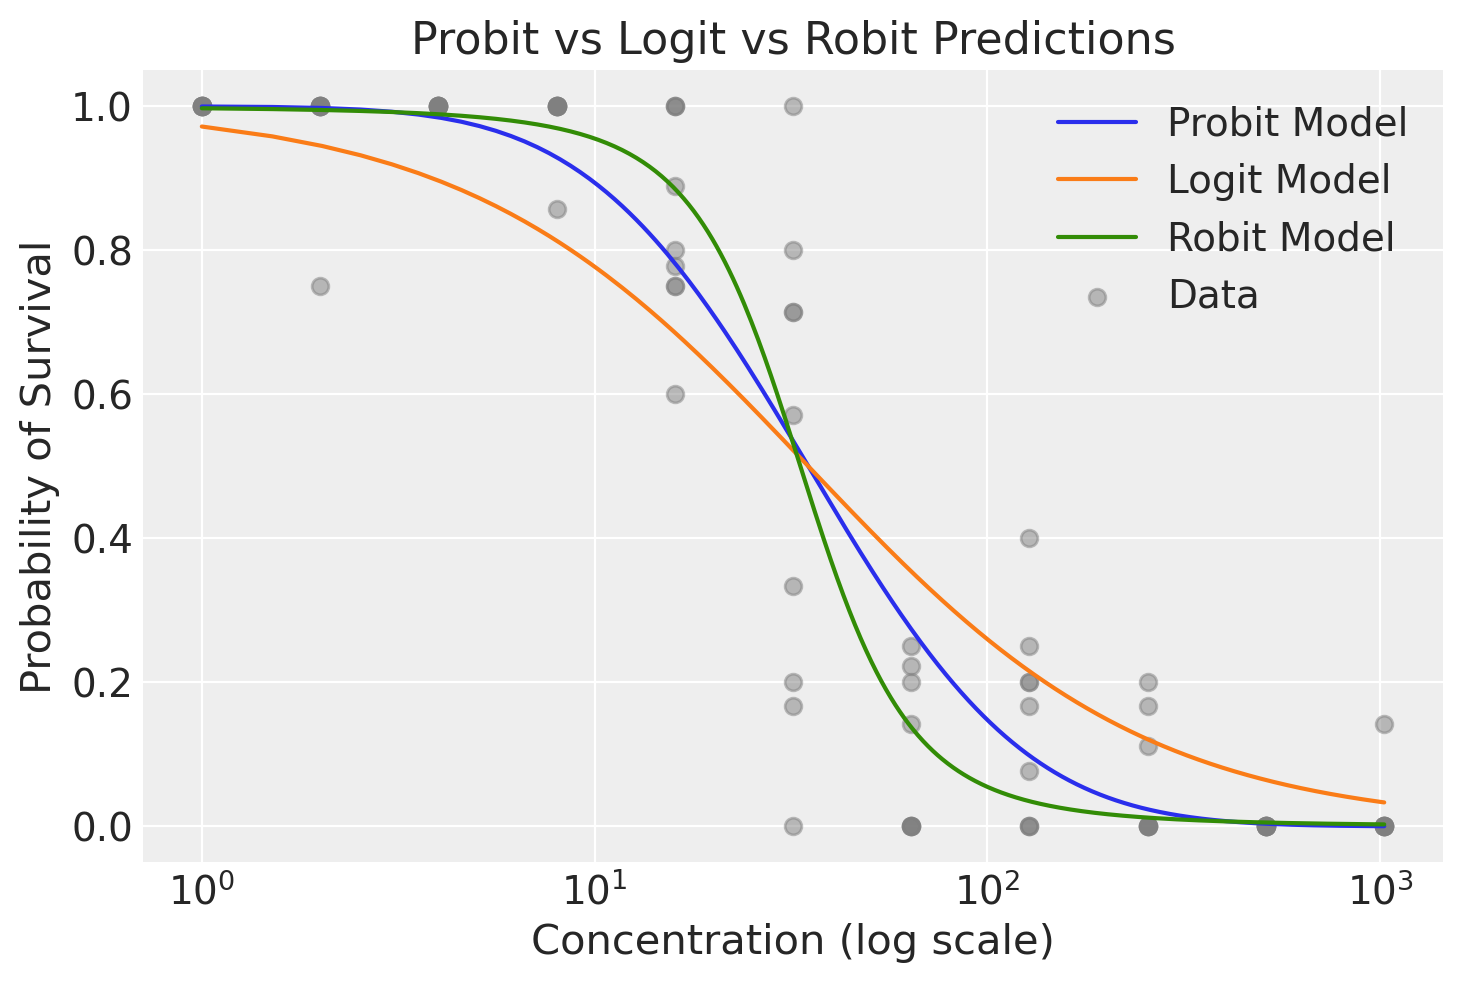

In [119]:
plt.plot(conc_range, p_probit, label="Probit Model")
plt.plot(conc_range, p_logit, label="Logit Model")
plt.plot(conc_range, p_robit, label="Robit Model")
plt.scatter(df['conc'], df['Nsurv']/df['N0'], color='gray', alpha=0.5, label="Data")
plt.xlabel("Concentration (log scale)")
plt.xscale("log")
plt.ylabel("Probability of Survival")
plt.legend()
plt.title("Probit vs Logit vs Robit Predictions")
plt.show()

    we notice that the Robit link allows a more steeper line (because it effectively downweights the influence of points that do not appear to fit the model.)

### Explore the space of priors ( since  the init normal distribution is weakly informative )